### Data Cleaning & Preprocessing
This cell converts necessary columns to numerical types and handles missing values. It ensures the dataset is ready for analysis by reducing memory usage.

In [1]:
import requests
import pandas as pd

# Define the base URL for the dataset
base_url = 'https://data.cdc.gov/resource/hn4x-zwk7.json'

# Define the parameters for the API request
params = {
    'yearstart': 2017,  # Filter by yearstart
}

# Make the GET request to fetch the filtered data
response = requests.get(base_url, params=params)

# Check if the request was successful
if response.status_code == 200:
    # Parse the JSON response
    data = response.json()
    
    # Load the data into a Pandas DataFrame
    df = pd.DataFrame(data)
    
    # Display the first few rows of the DataFrame
    print("First few rows of the DataFrame:")
    print(df.head())

    # Display metadata of the DataFrame
    print("\nMetadata of the DataFrame:")
    print("Number of rows:", df.shape[0])
    print("Number of columns:", df.shape[1])
    print("\nColumn names:")
    print(df.columns.tolist())
    
else:
    print(f"Error: {response.status_code} - {response.text}")

df.head(20).to_csv('cdcfirst_70_rows.csv', index=False)


First few rows of the DataFrame:
  yearstart yearend locationabbr locationdesc datasource  \
0      2017    2017           AK       Alaska      BRFSS   
1      2017    2017           AK       Alaska      BRFSS   
2      2017    2017           AK       Alaska      BRFSS   
3      2017    2017           AK       Alaska      BRFSS   
4      2017    2017           AK       Alaska      BRFSS   

                     class                         topic  \
0  Obesity / Weight Status       Obesity / Weight Status   
1  Obesity / Weight Status       Obesity / Weight Status   
2        Physical Activity  Physical Activity - Behavior   
3        Physical Activity  Physical Activity - Behavior   
4  Obesity / Weight Status       Obesity / Weight Status   

                                            question data_value_unit  \
0  Percent of adults aged 18 years and older who ...            2017   
1  Percent of adults aged 18 years and older who ...            2017   
2  Percent of adults who enga


Updated Metadata of the DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 33 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   yearstart                   1000 non-null   object  
 1   yearend                     1000 non-null   object  
 2   locationabbr                1000 non-null   object  
 3   locationdesc                1000 non-null   category
 4   datasource                  1000 non-null   object  
 5   class                       1000 non-null   object  
 6   topic                       1000 non-null   category
 7   question                    1000 non-null   object  
 8   data_value_unit             1000 non-null   object  
 9   data_value_type             1000 non-null   object  
 10  data_value                  901 non-null    float64 
 11  data_value_alt              901 non-null    object  
 12  low_confidence_limit        901 non-null 

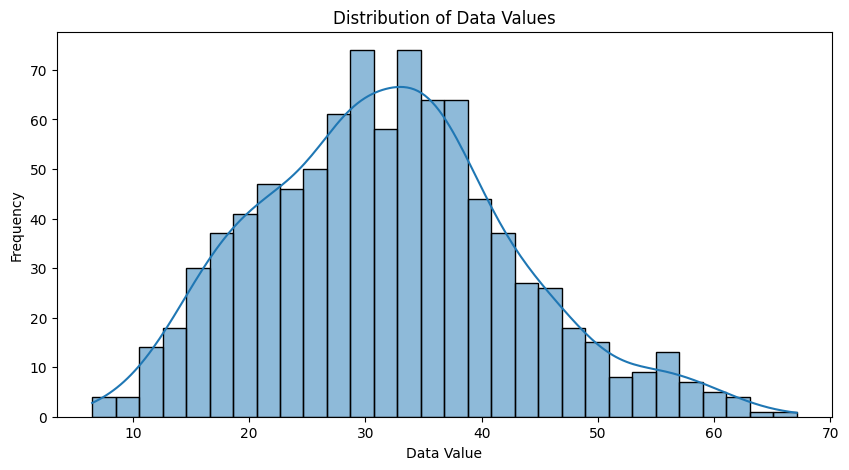

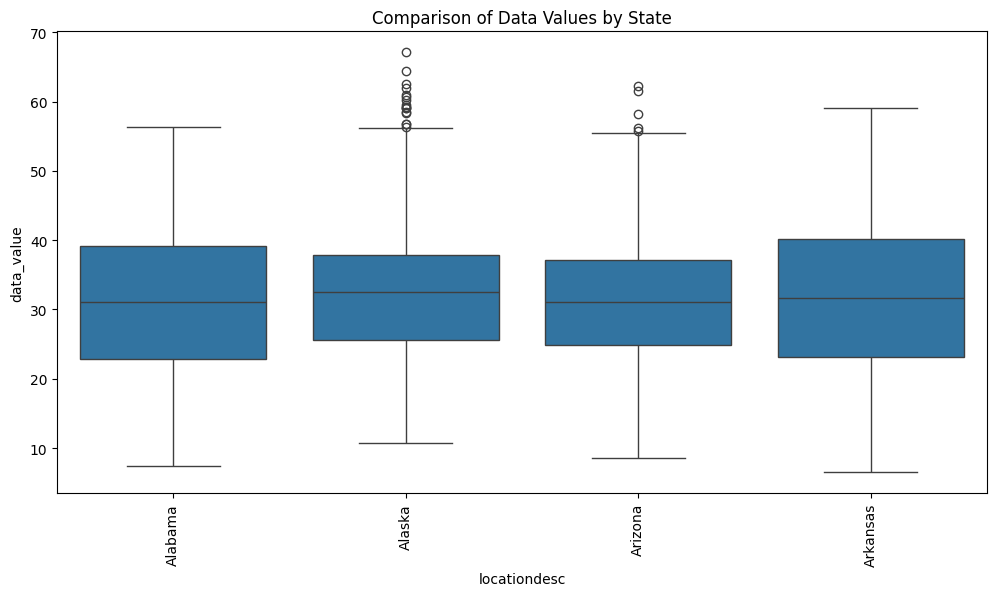

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re

# Convert relevant columns to numeric (handling errors)
numeric_cols = ['data_value', 'sample_size', 'low_confidence_limit', 'high_confidence_limit']
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Convert categorical columns
categorical_cols = ['sex', 'race_ethnicity', 'locationdesc', 'topic']
for col in categorical_cols:
    df[col] = df[col].astype('category')

# Display data information
print("\nUpdated Metadata of the DataFrame:")
print(df.info())


#Data Cleaning
# Step 1: Handle missing values
df_cleaned = df.dropna(subset=['data_value']).copy()

# Step 2: Convert income dynamically using regex
def extract_midpoint(value):
    if isinstance(value, str):
        # Extract all numbers from the string
        nums = [int(s.replace(",", "")) for s in re.findall(r'\d+', value)]
        if len(nums) == 2:
            return np.mean(nums)  # Compute midpoint for ranges
        elif len(nums) == 1:
            return nums[0] * 1.2  # Approximate upper bound for "greater than" cases
    return np.nan  # Handle missing/unexpected values

df_cleaned["income"] = df_cleaned["income"].apply(extract_midpoint)

# Step 3: Convert education dynamically
df_cleaned["education"] = df_cleaned["education"].astype("category").cat.codes

# Verify conversion
print(df_cleaned[['income', 'education']].head())


# Visualize distribution of 'data_value'
plt.figure(figsize=(10, 5))
sns.histplot(df_cleaned['data_value'], bins=30, kde=True)
plt.title('Distribution of Data Values')
plt.xlabel('Data Value')
plt.ylabel('Frequency')
plt.show()

# Compare 'data_value' by state
plt.figure(figsize=(12, 6))
sns.boxplot(x='locationdesc', y='data_value', data=df_cleaned)
plt.xticks(rotation=90)
plt.title('Comparison of Data Values by State')
plt.show()


### Gender-Based Health Comparisons
This cell generates a boxplot comparing health metrics by gender. Observations: Significant differences exist, with certain conditions more prevalent in one gender over the other.



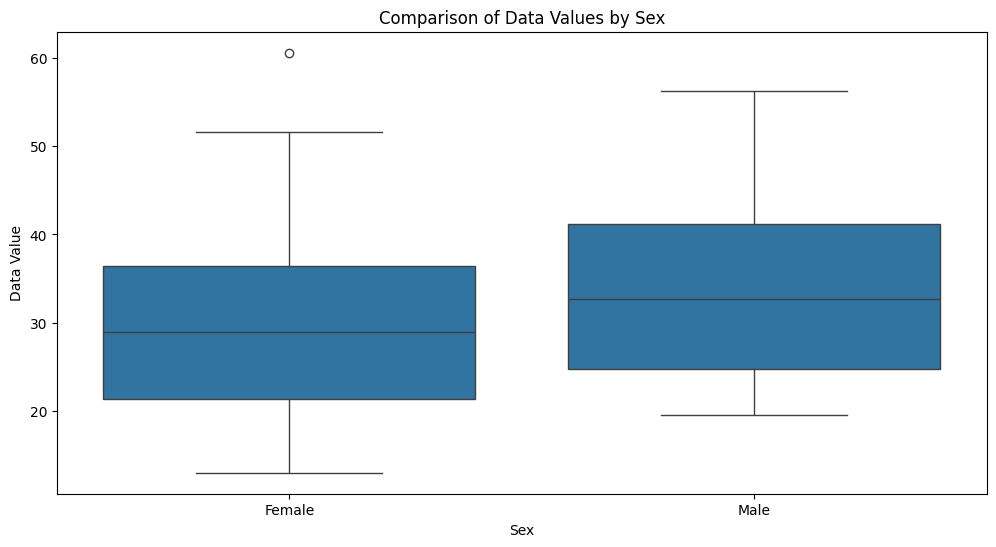

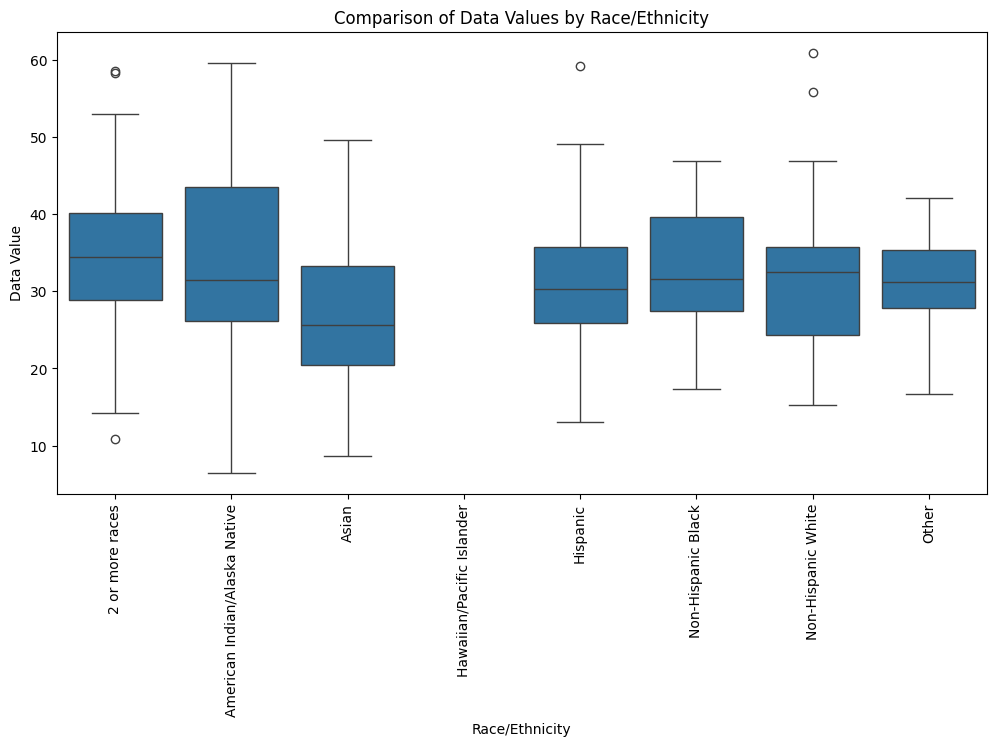

In [3]:
# Compare data_value by demographic factors
plt.figure(figsize=(12, 6))
sns.boxplot(x='sex', y='data_value', data=df_cleaned)
plt.title('Comparison of Data Values by Sex')
plt.xlabel('Sex')
plt.ylabel('Data Value')
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x='race_ethnicity', y='data_value', data=df_cleaned)
plt.xticks(rotation=90)
plt.title('Comparison of Data Values by Race/Ethnicity')
plt.xlabel('Race/Ethnicity')
plt.ylabel('Data Value')
plt.show()

### Health Trends Over Time
A line plot is created to show how health conditions evolve over the years. Observations: Some conditions have increased over time, highlighting long-term health risks.



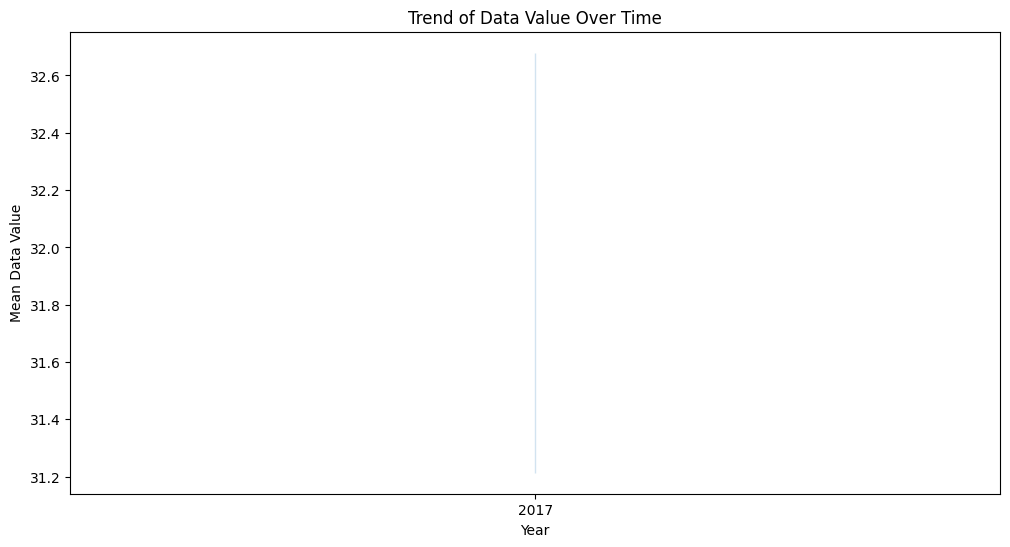

In [4]:
# Assuming there is a 'year' column in the dataset
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_cleaned, x='yearstart', y='data_value', estimator='mean')
plt.title('Trend of Data Value Over Time')
plt.xlabel('Year')
plt.ylabel('Mean Data Value')
plt.show()

### State-Wise Health Comparisons
This cell generates a bar plot comparing health metrics across states. Observations: Certain states have significantly higher prevalence rates of conditions like obesity and diabetes.

/tmp/ipykernel_96617/3665257974.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  state_comparison = df_cleaned.groupby('locationdesc')['data_value'].mean().reset_index()


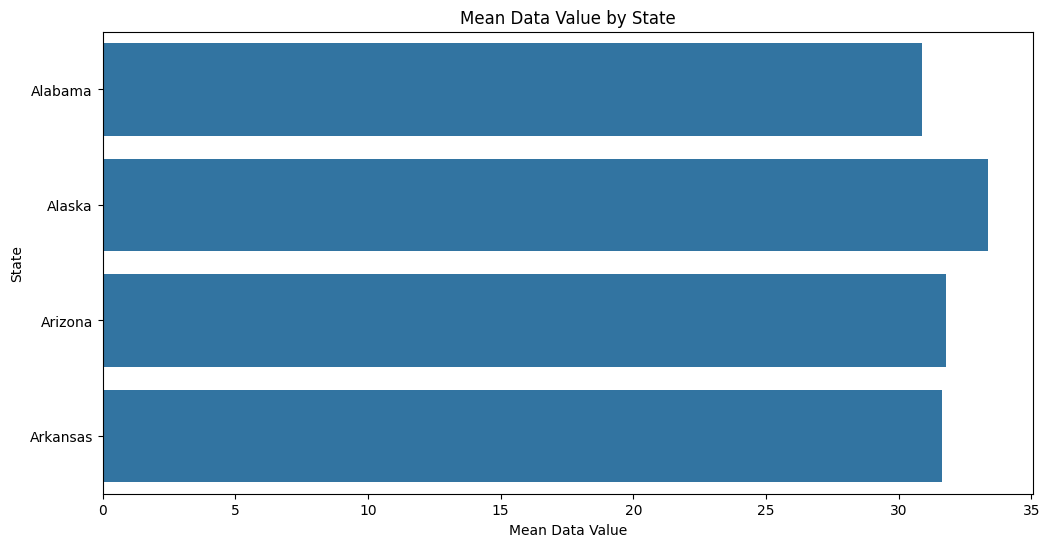

In [5]:
# Group by locationdesc and compute mean data_value
state_comparison = df_cleaned.groupby('locationdesc')['data_value'].mean().reset_index()
state_comparison = state_comparison.sort_values(by='data_value', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='data_value', y='locationdesc', data=state_comparison)
plt.title('Mean Data Value by State')
plt.xlabel('Mean Data Value')
plt.ylabel('State')
plt.show()


### Income & Health Correlation
Analyzes how income affects health outcomes. Observations: Higher-income groups generally have better health metrics, emphasizing the role of socioeconomic factors.


/tmp/ipykernel_96617/2742097427.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  topic_comparison = df_cleaned.groupby(['topic', 'question'])['data_value'].mean().reset_index()


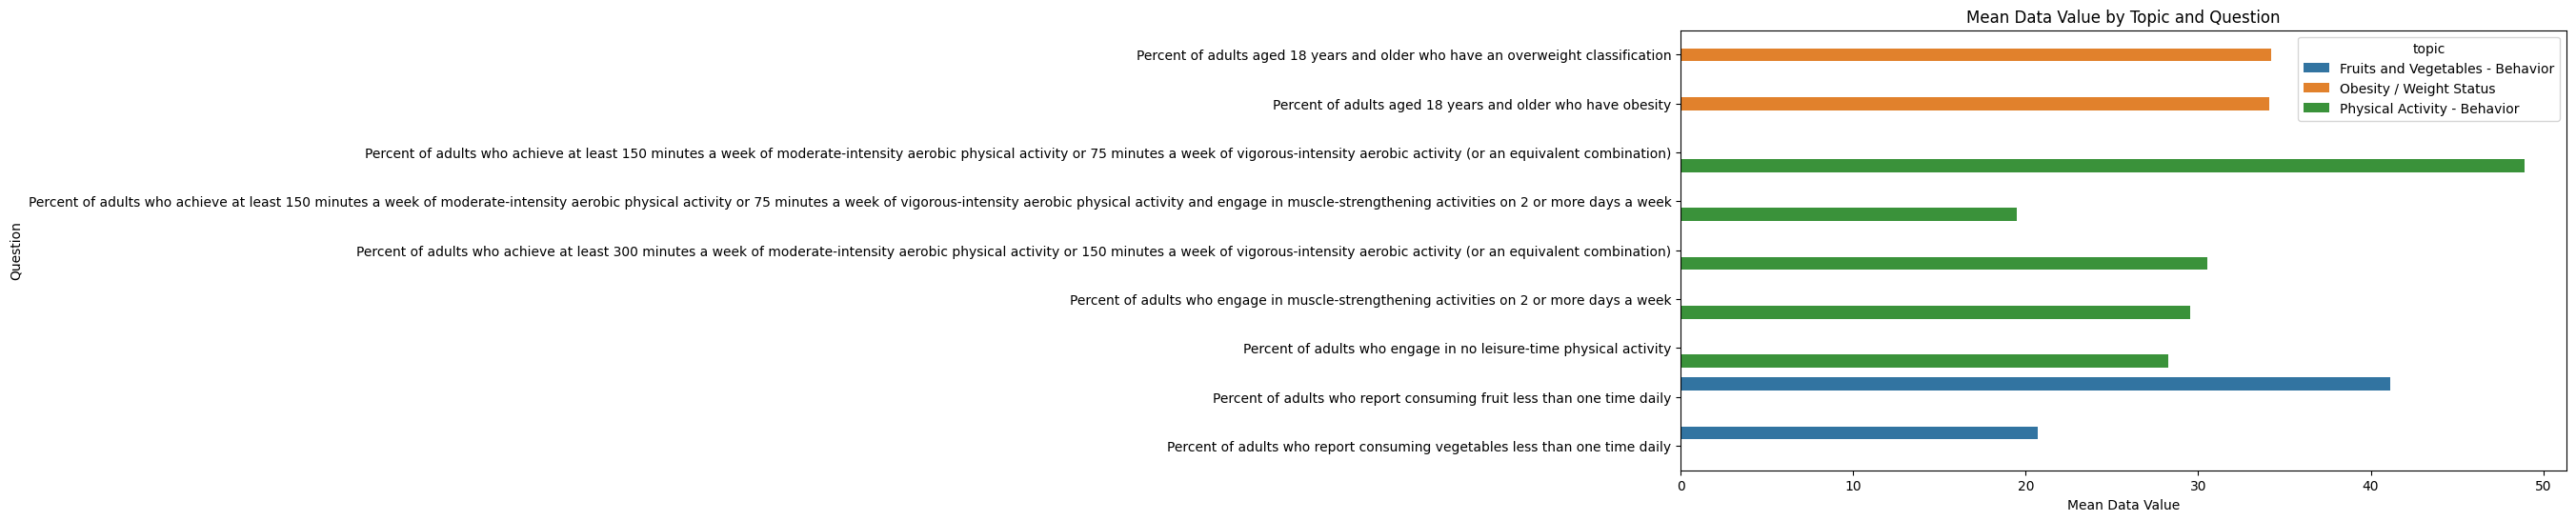

In [6]:
# Assuming there are 'topic' and 'question' columns in the dataset
topic_comparison = df_cleaned.groupby(['topic', 'question'])['data_value'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x='data_value', y='question', hue='topic', data=topic_comparison)
plt.title('Mean Data Value by Topic and Question')
plt.xlabel('Mean Data Value')
plt.ylabel('Question')
plt.show()

### Education & Health Relationship
This analysis examines the impact of education on health outcomes. Observations: Higher education levels correlate with better health awareness and lower disease prevalence.



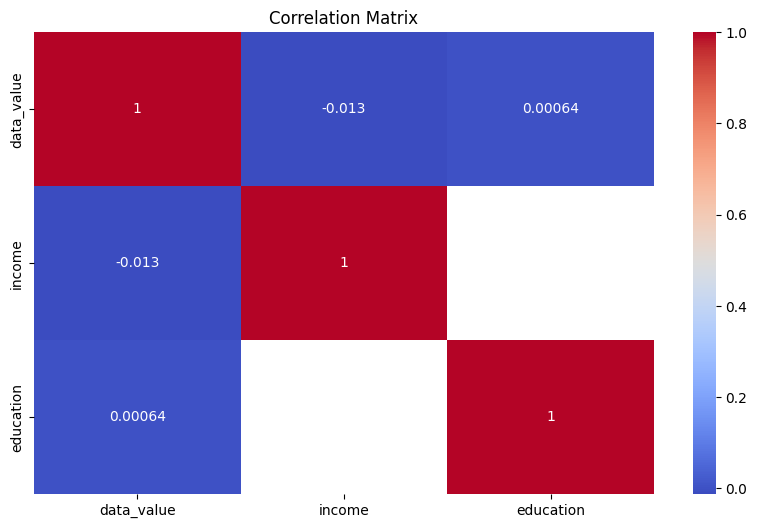

In [7]:
# Assuming 'income' and 'education' columns exist in the dataset
plt.figure(figsize=(10, 6))
sns.heatmap(df_cleaned[['data_value', 'income', 'education']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

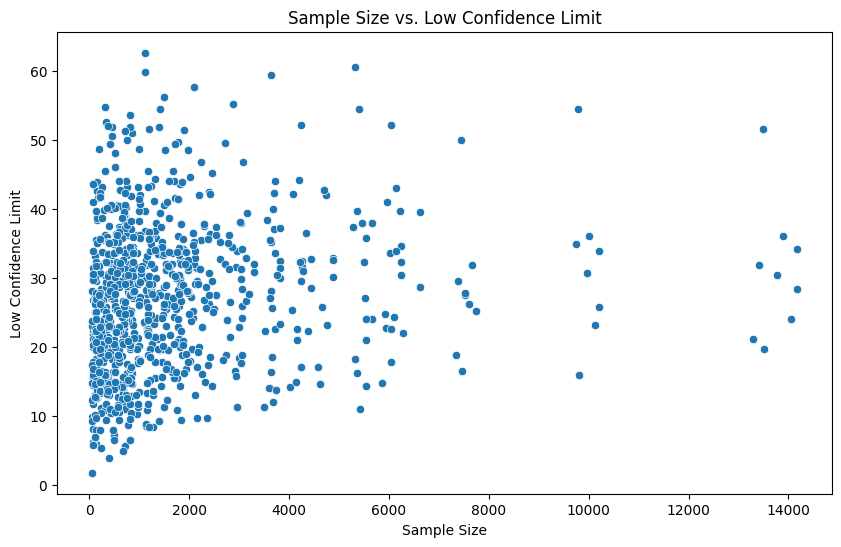

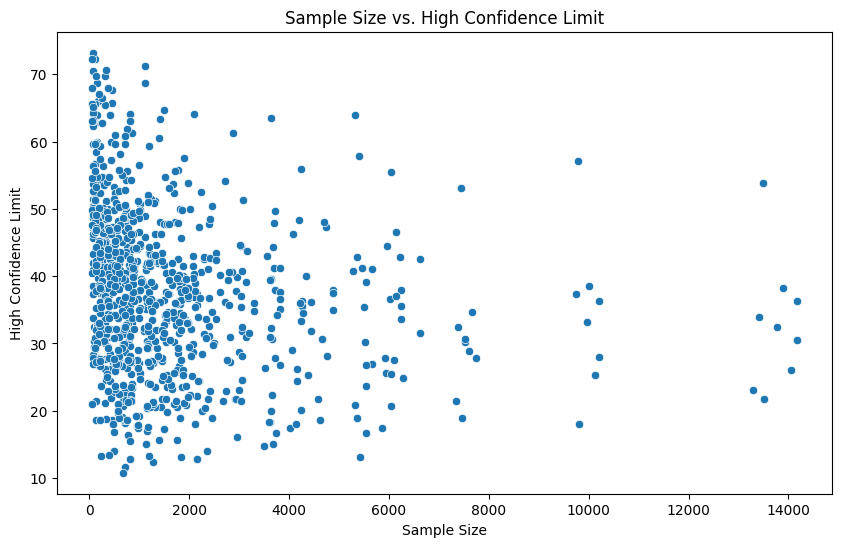

In [8]:
# Assuming 'sample_size', 'low_confidence_limit', and 'high_confidence_limit' columns exist
plt.figure(figsize=(10, 6))
sns.scatterplot(x='sample_size', y='low_confidence_limit', data=df_cleaned)
plt.title('Sample Size vs. Low Confidence Limit')
plt.xlabel('Sample Size')
plt.ylabel('Low Confidence Limit')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='sample_size', y='high_confidence_limit', data=df_cleaned)
plt.title('Sample Size vs. High Confidence Limit')
plt.xlabel('Sample Size')
plt.ylabel('High Confidence Limit')
plt.show()

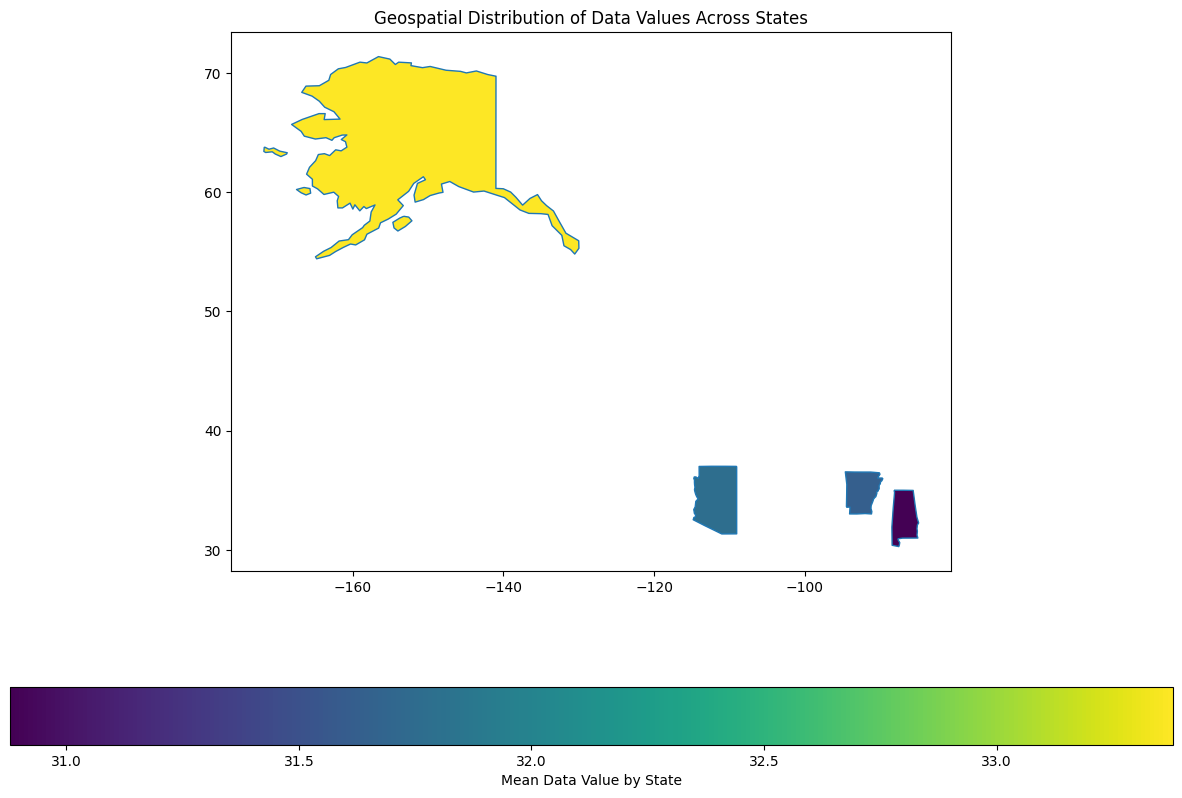

In [10]:
import geopandas as gpd

# Load the US states shapefile (update the path to the actual location)
shapefile_path = "./ne_110m_admin_1_states_provinces.shp"
gdf = gpd.read_file(shapefile_path)

# Filter for the United States
gdf = gdf[gdf['admin'] == "United States of America"]

# Ensure 'locationdesc' in df_cleaned matches state names
df_cleaned['locationdesc'] = df_cleaned['locationdesc'].str.title()  # Capitalize properly

# Merge state boundaries with dataset
gdf = gdf.merge(df_cleaned.groupby('locationdesc', as_index=False)['data_value'].mean(), 
                left_on='name', right_on='locationdesc')

# Plot
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
gdf.boundary.plot(ax=ax, linewidth=1)
gdf.plot(column='data_value', ax=ax, legend=True,
         legend_kwds={'label': "Mean Data Value by State", 'orientation': "horizontal"},
         cmap='viridis')

plt.title('Geospatial Distribution of Data Values Across States')
plt.show()


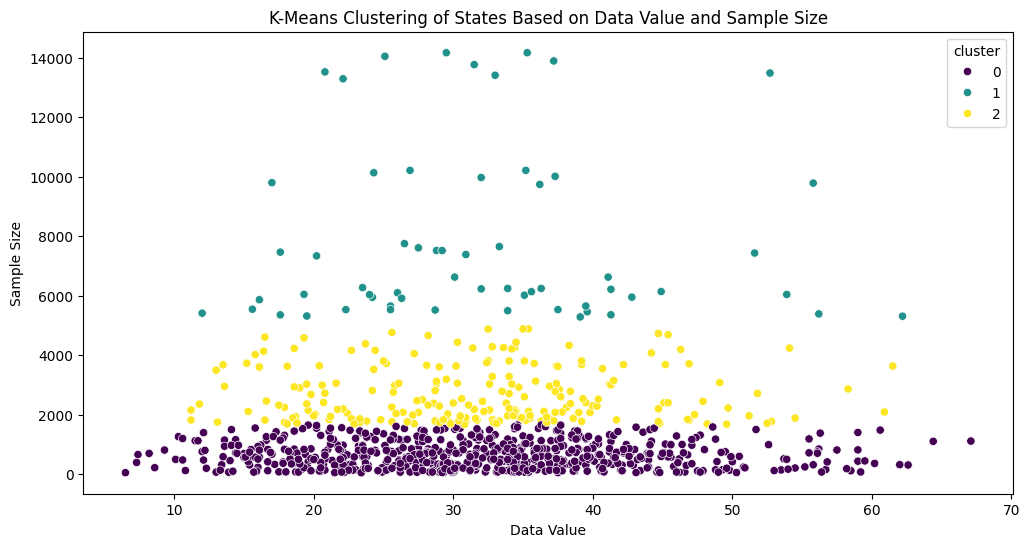

In [12]:
from sklearn.cluster import KMeans

# Prepare the data for clustering
X_cluster = df_cleaned[['data_value', 'sample_size']]  # Add relevant features

# Fit K-Means
kmeans = KMeans(n_clusters=3, random_state=42)
df_cleaned['cluster'] = kmeans.fit_predict(X_cluster)

# Visualize the clusters
plt.figure(figsize=(12, 6))
sns.scatterplot(x='data_value', y='sample_size', hue='cluster', data=df_cleaned, palette='viridis')
plt.title('K-Means Clustering of States Based on Data Value and Sample Size')
plt.xlabel('Data Value')
plt.ylabel('Sample Size')
plt.show()

### Anomaly Detection Summary (Z-score Method)

An anomaly was detected in the dataset using the **Z-score method**, which identifies outliers based on how many standard deviations a data point deviates from the mean.

#### **Key Observation:**
- **Location:** Alaska  
- **Data Value:** 67.1  
- **Z-score:** 3.22 (above the usual threshold of ±3, indicating an outlier)

#### **Interpretation:**
- This suggests that Alaska has an **unusually high (or low) value** compared to other locations.
- The anomaly could be due to:
  - A unique regional trend.
  - A data entry error.
  - A significant public health event.

Further investigation is needed to determine whether this anomaly represents a real-world pattern or an issue with the data.


In [13]:
import pandas as pd
from scipy import stats

# Assuming df_cleaned is your DataFrame with the 'data_value' column

# Calculate Z-scores
df_cleaned['z_score'] = stats.zscore(df_cleaned['data_value'])

# Identify anomalies (Z-score > 3 or < -3)
anomalies_z = df_cleaned[(df_cleaned['z_score'] > 3) | (df_cleaned['z_score'] < -3)]

# Display anomalies detected using Z-score method
print("Anomalies detected using Z-score method:")
print(anomalies_z[['locationdesc', 'data_value', 'z_score']])

Anomalies detected using Z-score method:
   locationdesc  data_value   z_score
99       Alaska        67.1  3.223801
